## Covid-19 X-ray images classification

#### Author: Yilin Xu

#### Date: Oct.6.2020

--------
#### Introduction:
- " The novel coronavirus 2019 (COVID-2019), which first appeared in Wuhan city of China in December 2019, spread rapidly around the world and became a pandemic. It has caused a devastating effect on both daily lives, public health, and the global economy. It is critical to detect the positive cases as early as possible so as to prevent the further spread of this epidemic and to quickly treat affected patients. The need for auxiliary diagnostic tools has increased as there are no accurate automated toolkits available. Recent findings obtained using radiology imaging techniques suggest that such images contain salient information about the COVID-19 virus. Application of advanced artificial intelligence (AI) techniques coupled with radiological imaging can be helpful for the accurate detection of this disease, and can also be assistive to overcome the problem of a lack of specialized physicians in remote villages."


- This notebook is a replication of the DarkCovidNet model[^1] to classify COVID-19 x-ray images from "No finding" images to assist COVID-19 diagnosis and an extension of the notebook published along with the paper in github https://github.com/muhammedtalo/COVID-19/blob/master/DarkCovidNet%20%20for%20binary%20classes.ipynb. We use data available in the Chicagoland Pandemic Response Commons (CRPC) for this notebook.

[^1]: Ozturk et. al. 2020. Automated detection of COVID-19 cases using deep neural networks with X-ray. Comput Biol Med. 2020 Jun; 121: 103792. (doi: 10.1016/j.compbiomed.2020.103792).

----------
#### Data Source: 

- open-COXRAY project in  the CPRC  contains X-ray images for COVID-19 patients imported from https://github.com/ieee8023/covid-chestxray-dataset. X-ray images for COVID-19 patients are queried and downloaded for image classification.



- open-ChestX-ray8 project in the CPRC contains X-ray images for No finding individuals imported from https://github.com/muhammedtalo/COVID-19/tree/master/X-Ray%20Image%20DataSet/No_findings. X-ray images for No finding individuals are queried and downloaded.

--------
#### Set up notebook

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

The Vision module in fastai package contains the classification methods we will use. Uncomment to install python package.


In [2]:
# !pip install fastai==1.0.61 --user --no-use-pep517
# !pip install gitpython
# !pip install gen3
from fastai.vision import *
import numpy as np
from pathlib import Path
import os
import peregrine as pg
from gen3.auth import Gen3AuthError

### DarkCovidNet for three classes

--------
#### Query and download image data from Chicagoland Pandemic Data Commons for three classes

Query GUID for image data classfied as "No finding", "Pneumonia" and "COVID-19 Cases"

In [3]:
# Query image object id and clinical note information
images_info = pg.get_images("open-ChestX-ray8")

In [4]:
# Query image object id and clinical note for COVID19 cases
covid_info = pg.get_observation_images("open-COXRAY")

Download image files for No finding cases

In [5]:
# Subset no finding rows
is_no_finding =  images_info['clinical_notes']=='No_findings'
no_findings = images_info[is_no_finding]

In [6]:
# Create three_classes_images/no_finding dir if not exist
os.makedirs('three_classes_images/no_finding', exist_ok=True)
os.chdir('three_classes_images/no_finding')
# Download image files
no_findings['GUID'].apply(lambda x: pg.download_object(x))
os.chdir('../../')

Download image files for Pneumonia cases

In [7]:
# Subset Pneumonia rows
is_pneumonia =  images_info['clinical_notes']=='Pneumonia'
pneumonia = images_info[is_pneumonia]

In [8]:
# Create three_classes_images/no_finding dir if not exist
os.makedirs('three_classes_images/pneumonia', exist_ok=True)
os.chdir('three_classes_images/pneumonia')
# Download image files
pneumonia['GUID'].apply(lambda x: pg.download_object(x))
os.chdir('../../')

Download image files for COVID-19 cases

In [9]:
# Create three_classes_images/covid19 dir if not exist
os.makedirs('three_classes_images/covid19', exist_ok=True)
os.chdir('three_classes_images/covid19')
# Download image files
covid_info['GUID'].apply(lambda x: pg.download_object(x))
os.chdir('../../')

--------

#### Load Image data as ImageDataBunch object

Declare path of image files which are organized in different folders representing distinct categories.

In [10]:
path = Path('three_classes_images')

- All of the images are the 256 * 256 pixels and batch size is defined as 32

- The image data is normalized to have mean 0 and standard deviation of 1

- We randomly separate images to training and testing datasets in 8:2 ratio with random seed as 41


In [11]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train=".", valid_pct =0.2,
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=0).normalize()

 Show image group names, group numbers, size of training images and size of testing image.

In [12]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['covid19', 'no_finding', 'pneumonia'], 3, 1027, 256)

Show a subset of normalized x-ray images (3 row * 3 column)

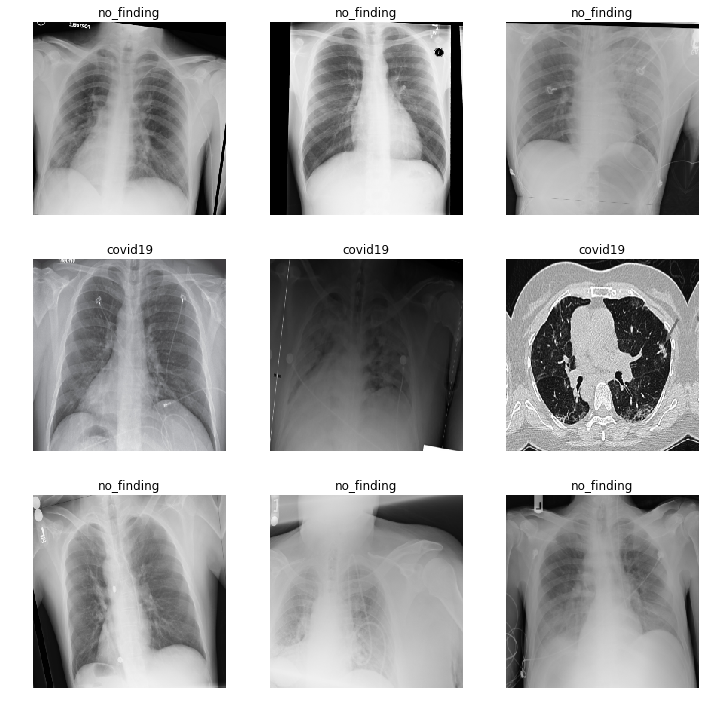

In [13]:
data.show_batch(rows=3, figsize=(10,10))

--------

#### Construct DarkCovidNet CNN for three classes (modified Darknet model)

- Define one layer of the convolutional neural network using fastai and PyTorch
- Each layer has one convolution, one normalization, and one activation
- We use LeakyReLU with a negative slope of 0.1 as the activation function

ni: number of input (number of channels in the input image).

nf: number of filter. 

size: kernel_size (size of the convolving kernel).

stride: skip number. 

padding: amount of pixels adding to the input image. 


In [14]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )


Define triple convolution layers.

In [15]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

Define maxpooling with size of 2 and stride of 2 to extract most activated presence of a feature

In [16]:
 def maxpooling():
    return nn.MaxPool2d(2, stride=2)

- Construct DarkCovidNet architecture with 17 convolution layers
- The number of filters are gradually increased (e.g., 8,16,32)


In [17]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

--------

#### Train DarkCovidNet CNN

Use fastai.vision.learner to train a randomly initialized model. Our loss function, Cross-entropy loss, or log loss, measures the performance of a classification model as a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label.

In [18]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

DarkCovidNet CNN summary

In [19]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

Plot the learning rate vs loss to identify the maximum learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


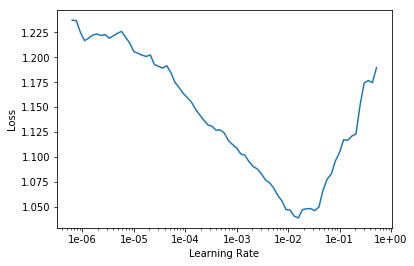

In [20]:
learn.lr_find()
learn.recorder.plot()

When training Deep Learning models with Fastai it is recommended to use the fit_one_cycle() method, due to its better performance in speed and accuracy, over the fit() method. In short, fit_one_cycle() is Fastai’s implementation of Leslie Smith’s 1cycle policy. Here we set Epoch = 150, maximum learning rate = 3e-3.

In [21]:
epoch = 150
learn.fit_one_cycle(epoch, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.931959,1.041830,0.433594,01:07
1,0.865732,0.739800,0.667969,01:08
2,0.792278,0.709021,0.699219,01:07
3,0.751670,0.727642,0.648438,01:07
4,0.700602,0.608309,0.746094,01:08
5,0.670805,0.588714,0.753906,01:08
6,0.675985,0.609906,0.753906,01:08
7,0.659727,0.618103,0.707031,01:08
8,0.652505,0.776348,0.671875,01:08
9,0.647665,0.592117,0.757812,01:08


--------
#### Model Evaluation

#### Plot the Epoch and loss for both training data and validation data

The loss values decrease as the Epoch increases for both the training dataset and the validation dataset. When epoch exceeds 140, the loss values and accuracy values are stable. 150 Epoch is a good amount of times fitting the data to the model.


In [22]:
# Extract loss and accuracy values
segment = math.floor(len(data.train_ds)/32)
epoch_list = list(range(1,epoch+1))
index = [x*segment-1 for x in epoch_list]
train_loss = [float(learn.recorder.losses[i]) for i in index]
val_loss = learn.recorder.val_losses
accuracy = [float(x[0]) for x in learn.recorder.metrics]

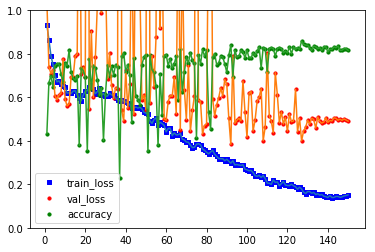

In [23]:
# Plot loss and accuracy values 
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylim([0, 1])
ax1.plot(epoch_list,train_loss,zorder=1) 
ax1.scatter(epoch_list, train_loss, s=10, c='b', marker="s", label='train_loss')
ax1.plot(epoch_list,val_loss,zorder=1) 
ax1.scatter(epoch_list,val_loss, s=10, c='r', marker="o", label='val_loss')
ax1.plot(epoch_list,accuracy,zorder=1) 
ax1.scatter(epoch_list,accuracy, s=10, c='g', marker="o", label='accuracy')
plt.legend(loc='lower left');
plt.show()


#### Evaluation precision, recall and f1 score for valication dataset and plot confusion matrix

In [24]:
# Extract probability and labels for validation datset
probs,targets = learn.get_preds(ds_type=DatasetType.Valid)
# Prediction 
probs = np.argmax(probs, axis=1)

In [25]:
# Calculate accuracy and plot the confusion matrix and classification report
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print("Accuracy:")
print(len(probs), correct, accuracy)
print("********")

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print("Confusion Matrix:")
print(cm1)
print("********")

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings','Pneumonia']
print("Classification Report:")
print(classification_report(y_true1, y_pred1, target_names=target_names))

Accuracy:
256 209 0.81640625
********
Confusion Matrix:
[[48  5  5]
 [ 0 89 18]
 [ 1 18 72]]
********
Classification Report:
              precision    recall  f1-score   support

    Covid-19       0.98      0.83      0.90        58
 No_findings       0.79      0.83      0.81       107
   Pneumonia       0.76      0.79      0.77        91

    accuracy                           0.82       256
   macro avg       0.84      0.82      0.83       256
weighted avg       0.82      0.82      0.82       256



- The accuracy of the model predicting COVID-19 cases with validation dataset is (48+89+72)/(58+107+91)=81.6%
- Among 58 COVID-19 images, 48 cases were predicted correctly. The recall rate for COVID-19 is 48/58 =83%
- Among 49 predicted COVID-19 cases, 48 cases are COVID-19. The precision rate for COVID-19 is 48/49=98% 
- F1 score for COVID-19 is (83%+98%)/2 = 90%
- Among 107 No finding cases, 89 cases were predicted correctly. The recall rate for No finding is 89/107=83%
- Among 112 predicted No finding cases, 89 cases are No finding. The precision rate for No finding is 89/112=79%
- F1 score for No finding is (83%+79%)/2=81%
- Among 91 Pneumonia cases, 72 cases were predicted correctly. The recall rate for Pneumonia is 72/91=79%
- Among 95 predicted Pneumonia cases, 72 cases are Pneumonia cases. The precision rate for Pneumonia is 72/95=76%
- F1 score for Pneumonia is (79%+76%)/2=77%

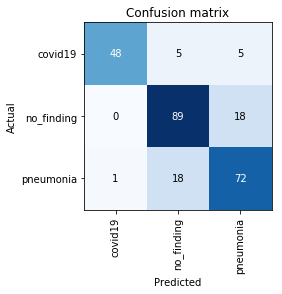

In [26]:
# Plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

--------
#### Conclusion

We applied DarkCovidNet model to classify x-ray images for “No finding”, Pneumonia, and COVID-19 cases. Training the model over 150 epochs showed that the losses for the training and validation datasets are stable and the model has an accuracy of 81.6%.

The confusion matrix suggests that the model could distinguish the COVID-19 cases from No findings or from Pneumonia cases with high precision  (100% and 98% respectively) and a recall rate of 90.5% (for both). Although the model performed poorly when differentiating “No finding” cases from Pneumonia cases, the main purpose of the model is to predict the COVID-19 cases.

This notebook highlights the power of deep neural networks for diagnosis of COVID-19, but also shows some of the limitations in differentiating between “No findings” and pneumonia.